# Prestudy 1 | Implementation of a sample Unet architecture
June 2020,
Linus Meienberg

Implementation and training of a unet architecture following the tutorial provided under 
https://keras.io/examples/vision/oxford_pets_image_segmentation/

The Oxford pet image dataset contains images of various cat and dog breeds that are annotated by pixel masks of the same size and assign background, border and interior pixels. 

In [1]:
import utility
import tensorflow
from tensorflow import keras as k 
from importlib import reload  


In [2]:
reload(utility)

<module 'utility' from 'c:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\Unet1\\utility.py'>

In [3]:
# The dataset is downladed under 
# Locate the dataset files
# X:\lillvis\temp\linus\OxfordPetDataset
#base_dir = 'X:/lillvis/temp/linus/OxfordPetDataset/'
# C:\Users\Linus Meienberg\Google Drive\Janelia\ImageSegmentation
base_dir = 'C:/Users/Linus Meienberg/Google Drive/Janelia/ImageSegmentation'

images, masks = utility.get_path_lists(base_dir)

# shuffle the images
images, masks = utility.shuffle_path_lists(images, masks)

# set aside a validation fraction
val_samples = 1000
images_train = images[:-val_samples]
masks_train = masks[:-val_samples]
images_test = images[-val_samples:]
masks_test = images[-val_samples:]


Number of samples: 7390


In [4]:
# Instantiate a Sequence object to stream the training and test set
batch_size = 32 #Batch size to use when evaluating the model
img_size = (160, 160)

train_gen = utility.OxfordPets(
    batch_size, img_size, images_train, masks_train
)
test_gen = utility.OxfordPets(batch_size, img_size, images_test, masks_test)

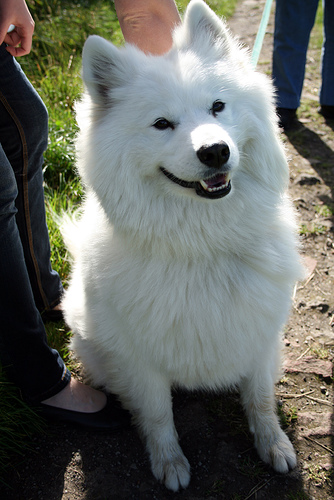

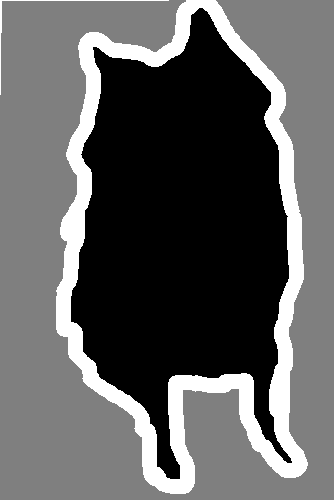

In [5]:
# Show one pair of an image and it's corresponding mask
utility.show_image_mask_pair(4, images_train, masks_train)

In [20]:
image_size = 572 # Use quadratic images just as in the unet paper to test
initial_features = 64 # Number of filter maps to apply in the first downsampling block

def build_unet(n_blocks = 2):
    # Specify the model input (what kind of tensor to expect)
    input = k.Input(shape= (image_size, image_size, 3),
                    batch_size= batch_size,
                    name = 'InputImage')

    
    # DOWNSAMPLING PATH
    filters = initial_features
    x = input # Use x to store the topmost layer
    outputs = [] # List to store the skip connection output of each downsampling block

    for n in range(n_blocks):
        # Apply a downsampling block
        # First Convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            name='down_{}_conv_1'.format(n+1))(x)
        # Second convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            name='down_{}_conv_2'.format(n+1))(x)
        # Max Pooling
        x = k.layers.MaxPool2D(pool_size=(2,2),
                            strides=(2,2),
                            name='down_{}_maxpool'.format(n+1))(x)
        outputs.append(x)
        # Update parameters for the next iteration
        filters *= 2 #double the number of filters
    
    # BRIDGE
    x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            name='bridge_conv_1'.format(n+1))(x)
    x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            name='bridge_conv_2'.format(n+1))(x)

    # UPSAMPLING PATH
    for n in range(n_blocks):
        # Apply an upsampling block
        # Update parameters for the next iteration
        filters /= 2 #half the number of filters
        # Upconvolution 
        x = k.layers.Conv2DTranspose(filters=filters,
                                     kernel_size=(3,3),
                                     padding='valid',
                                     name='up_{}_upconvolution'.format(n+1))(x)

        # Concatenate with cropped outputs in reverse order
        target_shape = x.output.shape # Shape of the output generated by the upsampling layer
        skip_input = outputs.pop() # Retrieve the last element appended to the list 
        given_shape = skip_input.output.shape # Shape of the output used in skip connection
        crop = (given_shape-target_shape)/2 # Difference of shapes divided by two for symmetric crop
        skip_input_cropped = k.layers.Cropping2D(cropping=crop,
                                                 name='up_{}_crop'.format(n+1))(skip_input)
        x = k.layers.Concatenate(name='up_{}_concat'.format(n+1))([x, skip_input_cropped])
        # First Convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            name='up_{}_conv_1'.format(n+1))(x)
        # Second convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            name='up_{}_conv_2'.format(n+1))(x)
        
    
    model = k.Model(inputs=input, outputs= x)
    return model 

In [21]:
unet = build_unet(n_blocks=2)
unet.summary()


TypeError: Dimension value must be integer or None or have an __index__ method, got 128.0